# Neural network regression

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import equinox as eqx
import matplotlib.pyplot as plt

In [2]:
def generative_f(x, weights):
    return weights * x

def generate_data(x, weights, y0, key):
    f = generative_f(x, weights)
    noise = random.normal(key=key, shape=x.shape)
    return y0 * jnp.exp( f + noise )

In [3]:
seed = 13
key = random.key(seed)
y_key, weight_key, model_key = random.split(key, 3)

In [4]:
y0 = 10.
n_samples = 100
x = jnp.linspace(start=0., stop=1., num=n_samples).reshape(-1, 1)
true_weights = random.normal(key=weight_key, shape=x.shape)
y = generate_data(x, true_weights, y0, y_key)

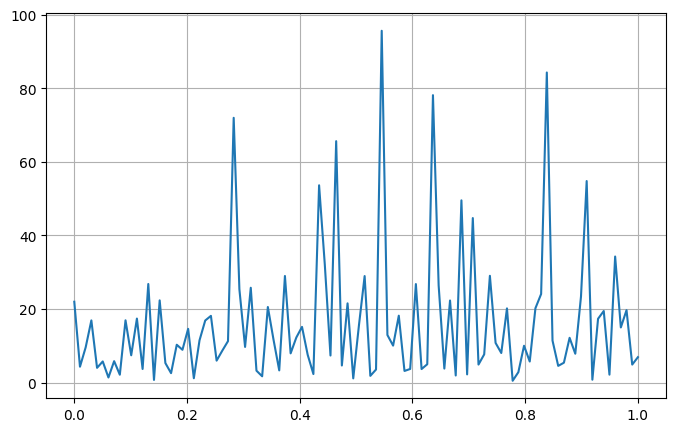

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x,y)
ax.grid(True)
plt.show()

In [6]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(1, 50, key=key1),
                       eqx.nn.Linear(50, 50, key=key2),
                       eqx.nn.Linear(50, 50, key=key3),
                       eqx.nn.Linear(50, 1, key=key4)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.ones(1)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x) + self.extra_bias

@jax.jit  # compile this function to make it run fast.
@jax.grad  # differentiate all floating-point arrays in `model`.
def loss(model, x, y):
    pred_y = jax.vmap(model)(x)  # vectorise the model over a batch of data
    return jax.numpy.mean((y - pred_y) ** 2)  # L2 loss

def train(model, x, y, learning_rate=0.001, epochs=100, clip_value=1.0):
    """
    Trains the model using gradient descent with gradient clipping.

    Args:
        model (NeuralNetwork): The model to train.
        x (jax.Array): Training data (inputs).
        y (jax.Array): Training data (labels).
        learning_rate (float): Learning rate for gradient descent.
        epochs (int): Number of training epochs.
        clip_value (float): Maximum allowed gradient value for clipping.

    Returns:
        NeuralNetwork: The trained model.
    """
    for epoch in range(epochs):
        # Compute gradients of the model with respect to the loss
        grads = loss(model, x, y)  
        
        # Clip the gradients to avoid exploding gradients
        #clipped_grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -clip_value, clip_value), grads)
        
        # Manually scale the gradients by the learning rate
        scaled_grads = jax.tree_util.tree_map(lambda g: -g * learning_rate, grads)
        
        # Update the model parameters with the scaled gradients
        model = eqx.apply_updates(model, scaled_grads)

        # Print loss every 10 epochs for monitoring
        if epoch % 10 == 0:
            current_loss = jax.jit(lambda m: jnp.mean((y - jax.vmap(m)(x)) ** 2))(model)
            print(f"Epoch {epoch}, Loss: {current_loss}")

    return model


In [7]:
model = NeuralNetwork(model_key)

In [8]:
trained_model = train(model, x, y, learning_rate=0.001, epochs=5000)

Epoch 0, Loss: 577.885009765625
Epoch 10, Loss: 546.9592895507812
Epoch 20, Loss: 481.9072570800781
Epoch 30, Loss: 340.44036865234375
Epoch 40, Loss: 337.18707275390625
Epoch 50, Loss: 337.0392761230469
Epoch 60, Loss: 336.9103088378906
Epoch 70, Loss: 336.79754638671875
Epoch 80, Loss: 336.69537353515625
Epoch 90, Loss: 336.6033630371094
Epoch 100, Loss: 336.52093505859375
Epoch 110, Loss: 336.4447937011719
Epoch 120, Loss: 336.3747253417969
Epoch 130, Loss: 336.3093566894531
Epoch 140, Loss: 336.2439880371094
Epoch 150, Loss: 336.1860046386719
Epoch 160, Loss: 336.12921142578125
Epoch 170, Loss: 336.07232666015625
Epoch 180, Loss: 336.0203857421875
Epoch 190, Loss: 335.96844482421875
Epoch 200, Loss: 335.9185485839844
Epoch 210, Loss: 335.8699035644531
Epoch 220, Loss: 335.8215637207031
Epoch 230, Loss: 335.77392578125
Epoch 240, Loss: 335.7239074707031
Epoch 250, Loss: 335.6756286621094
Epoch 260, Loss: 335.62750244140625
Epoch 270, Loss: 335.5777282714844
Epoch 280, Loss: 335.5263

In [9]:
prediction = []
for i in x:
    prediction.append(trained_model(i))
prediction = jnp.array(prediction)

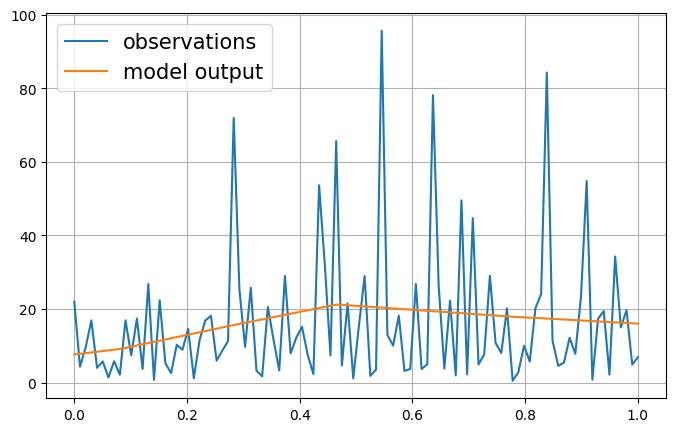

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x,y, label='observations')
#ax.plot(x, y0*jnp.exp(generative_f(x, true_weights) + 0.5), label='true mean')
ax.plot(x,prediction, label='model output')
ax.grid(True)
ax.legend(fontsize=15)
plt.show()